# Covid Detection

## Importing Libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import os
from PIL import Image

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms

## Setting up the GPU

In [29]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Creating Dataset

In [30]:
class ImagesDataset(Dataset):

    def __init__(self, root_dir, transform=None, ratio=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.ratio = ratio
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for c in self.classes:
            for img in os.listdir(os.path.join(root_dir, c)):
                sample = np.random.uniform()
                if sample <= self.ratio:
                    self.images.append(img)
                    self.labels.append(self.class_to_idx[c])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.classes[self.labels[idx]], self.images[idx])
        image = Image.open(img_name)
        image = image.convert(mode='RGB')
        label = self.labels[idx]

        PIL_transform = transforms.Compose([transforms.PILToTensor()])
        image = PIL_transform(image)
        image = image.float()

        # Apply additional transform 
        if self.transform:
            image = self.transform(image)

        return image, label

## Preprocessing the Images

### Normalizing the Images and Data Augmentation

In [31]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Normalize((0, 0, 0), (255, 255, 255)),
])

In [32]:
flip_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.Normalize((0, 0, 0), (255, 255, 255)),
])

In [33]:
rotate90_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(90),
    transforms.Normalize((0, 0, 0), (255, 255, 255)),
])

In [34]:
rotate180_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(180),
    transforms.Normalize((0, 0, 0), (255, 255, 255)),
])

In [35]:
rotate270_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(270),
    transforms.Normalize((0, 0, 0), (255, 255, 255)),
])

## Loading the Images

### Building the Dataset

In [36]:
# modify the root path based on your environment
root_dir = '/kaggle/input/xray-dataset-covid19/Covid_Dataset/xray_dataset_covid19/train'
original_dataset = ImagesDataset(root_dir, transform=transform)
flipped_dataset = ImagesDataset(root_dir, transform=flip_transform)
rotated90_dataset = ImagesDataset(root_dir, transform=rotate90_transform)
rotated180_dataset = ImagesDataset(root_dir, transform=rotate180_transform)
rotated270_dataset = ImagesDataset(root_dir, transform=rotate270_transform)

augmented_dataset = ConcatDataset([original_dataset, flipped_dataset, rotated90_dataset, rotated180_dataset, rotated270_dataset])

### Train-Test Split

In [37]:
# split augmneted dataset to train and validation
train_size = int(0.75 * len(augmented_dataset))
val_size = len(augmented_dataset) - train_size
train_dataset, val_dataset = random_split(augmented_dataset, [train_size, val_size])

# modify the root path based on your environment
root_dir = '/kaggle/input/xray-dataset-covid19/Covid_Dataset/xray_dataset_covid19/test'
test_dataset = ImagesDataset(root_dir, transform=transform)

### Creating the DataLoader

In [38]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([3, 150, 150])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


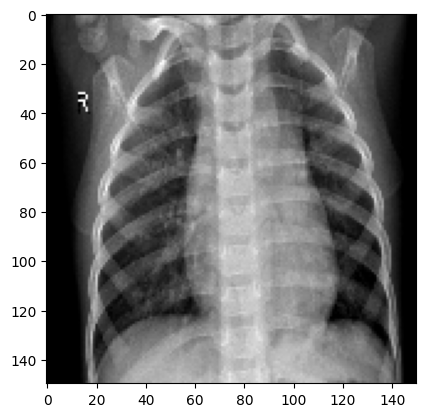

In [39]:
image = original_dataset[0][0]
print(image.shape)
plt.imshow(image.permute(1, 2, 0))
plt.show()

## Implementing the Model

In [40]:
class XrayCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.CNN_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 1),
            nn.Sigmoid() 
        )

    def forward(self, x: torch.Tensor):
        x = self.CNN_block(x)
        x = self.classifier(x)
        return x
    

## Training the Model

In [41]:
def train_model(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs):

    train_loss_vals = []
    train_num_preds = []
    train_cor_preds = []

    val_loss_vals = []
    val_num_preds = []
    val_cor_preds = []

    for epoch in tqdm.tqdm(range(num_epochs)):

        epoch_train_loss = []
        epoch_train_num_preds = 0
        epoch_train_cor_preds = 0

        model.train()

        for images, labels in train_data_loader:
            
            images = images.to(device)
            labels = labels.to(device)
            
            preds = model(images)
            preds = preds.squeeze(dim=1)

            loss = criterion(preds, labels.float())

            optimizer.zero_grad()

            loss.backward()
            epoch_train_loss.append(loss.item())

            optimizer.step()

            epoch_train_num_preds += len(labels)
            epoch_train_cor_preds += (preds.round() == labels).sum().item()

        train_loss_vals.append(np.mean(epoch_train_loss))
        train_num_preds.append(epoch_train_num_preds)
        train_cor_preds.append(epoch_train_cor_preds)

        epoch_val_loss = []
        epoch_val_num_preds = 0
        epoch_val_cor_preds = 0

        model.eval()

        with torch.no_grad():
            for images, labels in val_data_loader:

                images = images.to(device)
                labels = labels.to(device)

                preds = model(images)
                preds = preds.squeeze(dim=1)

                loss = criterion(preds, labels.float())

                epoch_val_loss.append(loss.item())

                epoch_val_num_preds += len(labels)
                epoch_val_cor_preds += (preds.round() == labels).sum().item()

        val_loss_vals.append(np.mean(epoch_val_loss))
        val_num_preds.append(epoch_val_num_preds)
        val_cor_preds.append(epoch_val_cor_preds)

    return train_loss_vals, train_num_preds, train_cor_preds, val_loss_vals, val_num_preds, val_cor_preds


In [42]:
def plot_training_summary(title, loss_vals, num_preds, cor_preds, epochs):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title + " loss")

    plt.subplot(1, 2, 2)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), np.array(cor_preds) / np.array(num_preds))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title + " accuracy")

    plt.tight_layout()
    plt.show()

## Evaluating the Model

In [43]:
def eval_model(model, data_loader):

    model.eval()

    num_preds = 0
    true_preds = 0

    lables = []
    preds = []

    with torch.no_grad():
        for images, labels in data_loader:

            images = images.to(device)
            labels = labels.to(device)

            pred_logits = model(images)
            pred_logits = pred_logits.squeeze(dim=1)   
            pred_labels = pred_logits.round()

            num_preds += len(labels)
            true_preds += (pred_labels == labels).sum().item()

            lables.append(labels.cpu().numpy())
            preds.append(pred_labels.cpu().numpy())
            
    lables = np.concatenate(lables)
    preds = np.concatenate(preds)

    return num_preds, true_preds, lables, preds


### Metrics

In [44]:
def calculate_metrics(actual, predicted):
    # 0 means Normal which is negative class
    # 1 means Covid19 which is positive class
    actual = np.where(actual == 0, 'Normal', 'Covid19')
    predicted = np.where(predicted == 0, 'Normal', 'Covid19')

    cm = confusion_matrix(actual, predicted, labels=['Normal', 'Covid19'])
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    sensitivity = recall
    specificity = tn / (tn + fp)
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    metrics = ['Accuracy', 'F1 Score', 'Precision', 'Sensitivity (Recall)', 'Specificity']
    values = [accuracy, f1, precision, sensitivity, specificity]
    probability_table = pd.DataFrame(values, index=metrics, columns=['Value'])
    return probability_table


### Confusion Matrix

In [45]:
def plot_confusion_matrix(labels, preds, classes):
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        cm = confusion_matrix(labels, preds)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

## Results

In [46]:
model = XrayCNN()
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [47]:
num_epochs = 10
loss_vals_training, num_preds_training, cor_preds_training, loss_vals_validation, num_preds_validation, cor_preds_validation = train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs)

100%|██████████| 10/10 [04:32<00:00, 27.22s/it]


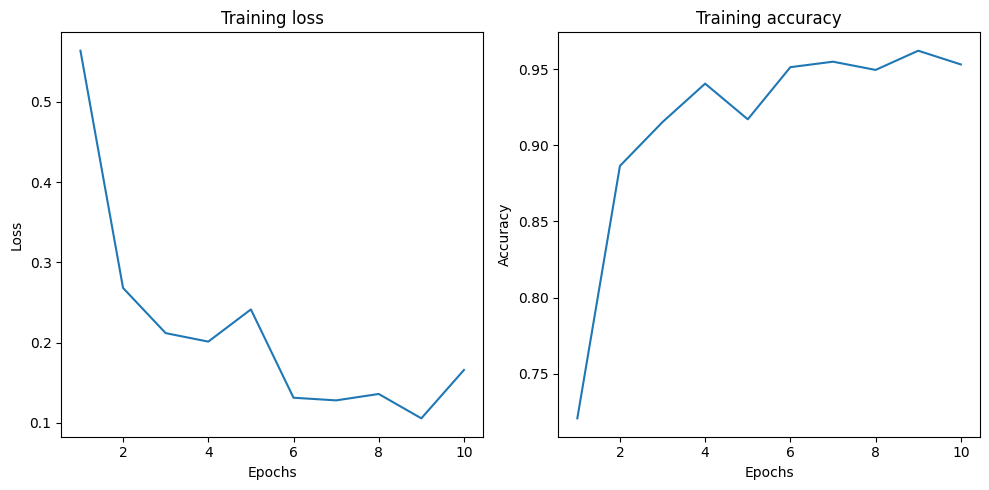

In [48]:
plot_training_summary('Training', loss_vals_training, num_preds_training, cor_preds_training, num_epochs)

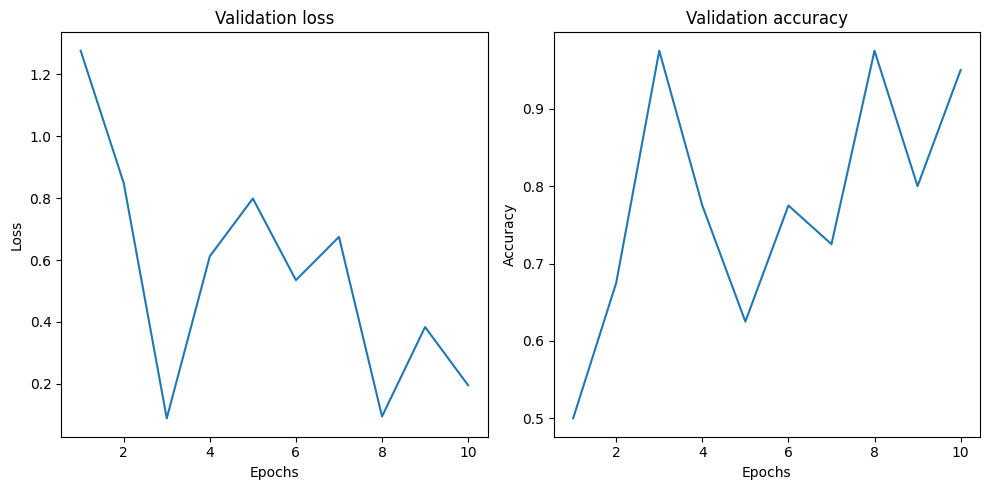

In [49]:
plot_training_summary('Validation', loss_vals_validation, num_preds_validation, cor_preds_validation, num_epochs)

In [50]:
num_preds_test, true_preds_test, labels_test, preds_test = eval_model(model, test_dataloader)

print(f'Test Accuracy: {true_preds_test / num_preds_test * 100:.2f}%')

Test Accuracy: 95.00%


In [51]:
calculate_metrics(labels_test, preds_test)

,Value
Accuracy,0.950000
F1 Score,0.952381
Precision,0.909091
Sensitivity (Recall),1.000000
Specificity,0.900000


In [52]:
print(labels_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


In [53]:
print(preds_test)

[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


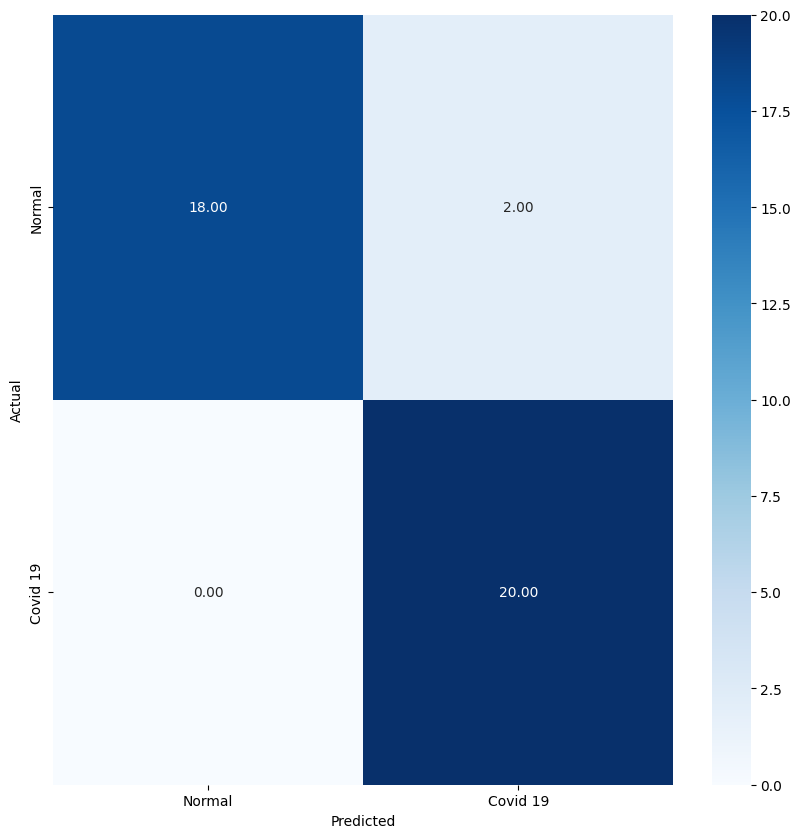

In [54]:
plot_confusion_matrix(labels_test, preds_test, ['Normal', 'Covid 19'])